<a href="https://colab.research.google.com/github/formesean/Tree-Image-Classifcation/blob/main/tree_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import needed libraries**

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

**Data Preparation**

In [4]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="fine")

# CIFAR-100 fine labels
cifar100_fine_labels = [
    "apple", "aquarium fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel",
    "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin",
    "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn mower", "leopard", "lion", "lizard", "lobster",
    "man", "maple", "motorcycle", "mountain", "mouse", "mushroom", "oak", "orange", "orchid", "otter", "palm", "pear", "pickup truck", "pine",
    "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper",
    "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout",
    "tulip", "turtle", "wardrobe", "whale", "willow", "wolf", "woman", "worm"
]

# Define tree categories
tree_classes = ["maple", "oak", "palm", "pine", "willow"]
tree_indices = [cifar100_fine_labels.index(tree) for tree in tree_classes]

# Filter dataset for only tree images
mask_train = np.isin(y_train, tree_indices)

# Get the corresponding indices of the tree class
mask_test = np.isin(y_test, tree_indices)

# Extract only tree images and their labels
x_train_trees = x_train[mask_train.flatten()]
y_train_trees = y_train[mask_train.flatten()]
x_test_trees = x_test[mask_test.flatten()]
y_test_trees = y_test[mask_test.flatten()]

# Convert labels to 0-4 instead of original indexes
y_train_trees = np.array([tree_indices.index(label) for label in y_train_trees.flatten()])
y_test_trees = np.array([tree_indices.index(label) for label in y_test_trees.flatten()])

print(f"Training samples: {len(x_train_trees)}, Testing samples: {len(x_test_trees)}")

# Visualize labels
df = pd.DataFrame({
    "Index": np.arange(len(y_train_trees)),
    "Tree Class": [tree_classes[label] for label in y_train_trees]
})

print(df.head(10))

Training samples: 2500, Testing samples: 500
   Index Tree Class
0      0     willow
1      1       pine
2      2       pine
3      3        oak
4      4      maple
5      5       palm
6      6      maple
7      7      maple
8      8       palm
9      9       pine


**View an image**

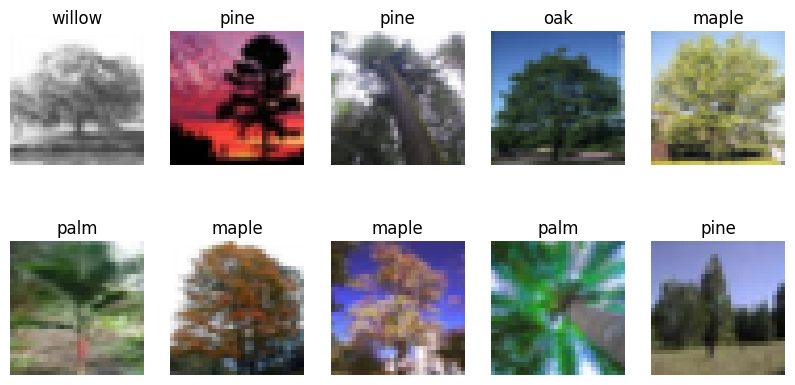

In [5]:
def plot_images(images, labels, classes, num=10):
    plt.figure(figsize=(10, 5))
    for i in range(num):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])           # Display image
        plt.title(classes[labels[i]])   # Display label
        plt.axis("off")
    plt.show()

plot_images(x_train_trees, y_train_trees, tree_classes, num=10)

**Build the CNN model**

In [6]:
model = Sequential([
    # Input layer
    Input(shape=(32, 32, 3)),

    # Hidden layer 1
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2, 2),

    # Hidden layer 2
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2, 2),

    # Hidden layer 3
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2, 2),

    # Hidden layer 4
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2, 2),

    # Hidden layer 5
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),

    # Output layer
    Dense(5, activation='softmax')
])

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 603,077 (2.30 MB)

 Trainable params: 603,077 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the model**

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

**Train model**

In [8]:
# Convert labels to one-hot encoding
y_train_trees = to_categorical(y_train_trees, num_classes=5)
y_test_trees = to_categorical(y_test_trees, num_classes=5)

model.fit(
    x_train_trees,
    y_train_trees,
    epochs=40,
    validation_split=0.3,
    shuffle=True
)

Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.2505 - loss: 87.1892 - val_accuracy: 0.3960 - val_loss: 1.4838
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.3478 - loss: 1.6031 - val_accuracy: 0.4600 - val_loss: 1.3587
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.4573 - loss: 1.3235 - val_accuracy: 0.4773 - val_loss: 1.3087
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.4977 - loss: 1.2163 - val_accuracy: 0.4853 - val_loss: 1.2556
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.5234 - loss: 1.1503 - val_accuracy: 0.4933 - val_loss: 1.3026
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.5054 - loss: 1.1568 - val_accuracy: 0.4693 - val_loss: 1.2966
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.5831 - loss: 1.0307 - val_accuracy: 0.4867 - val_loss: 1.2972
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.5683 - loss: 1.0701 - val_accurac

**Evaluate the model on the test set**

In [9]:
test_loss, test_acc = model.evaluate(x_test_trees, y_test_trees)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4948 - loss: 2.6327

Test Accuracy: 0.4940
Test Loss: 2.6433


**Predict on Test Samples**

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


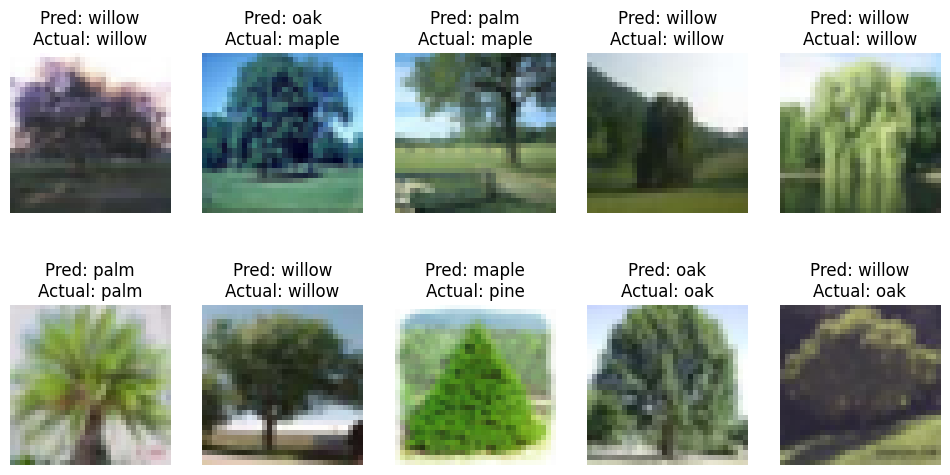

In [12]:
# Get predictions
predictions = model.predict(x_test_trees)

# Convert outputs to class labels
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_test_trees, axis=1)

# Select random test samples
num_samples = 10
random_indices = np.random.choice(len(x_test_trees), num_samples, replace=False)

# Plot images with actual and predicted labels
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_trees[idx])
    plt.title(f"Pred: {tree_classes[predicted_classes[idx]]}\nActual: {tree_classes[actual_classes[idx]]}")
    plt.axis("off")

plt.show()